<a href="https://colab.research.google.com/github/UJWAL-SHAH/ML/blob/master/Lab%20Work/ML_Lab5_J078.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fuel Consumption Regression**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget -O FuelConsumption.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv

--2020-09-01 10:58:24--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72629 (71K) [text/csv]
Saving to: ‘FuelConsumption.csv’

FuelConsumption.csv 100%[===================>]  70.93K   233KB/s    in 0.3s    

2020-09-01 10:58:25 (233 KB/s) - ‘FuelConsumption.csv’ saved [72629/72629]



In [3]:
data = pd.read_csv("FuelConsumption.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


In [5]:
data.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [6]:
data['FUELTYPE'].unique()

array(['Z', 'D', 'X', 'E'], dtype=object)

Do One-Hot Encoding in FUELTYPE not in Vehicleclass & Transmission as they have more than 15 unique values.So remove them only

In [7]:
dummy_variable_1 = pd.get_dummies(data["FUELTYPE"])
dummy_variable_1.head()

,D,E,X,Z
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [8]:
dummy_variable_1.rename(columns={'D':'fueltype-D', 'E':'fueltype-E','X':'fueltype-X','Z':'fueltype-Z'}, inplace=True)
dummy_variable_1.head()

,fueltype-D,fueltype-E,fueltype-X,fueltype-Z
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [9]:
# merge data frame "df" and "dummy_variable_1" 
data = pd.concat([data, dummy_variable_1], axis=1)

# drop original column "fuel-type" from "df"
data.drop("FUELTYPE", axis = 1, inplace=True)

In [10]:
data.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS,fueltype-D,fueltype-E,fueltype-X,fueltype-Z
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,9.9,6.7,8.5,33,196,0,0,0,1
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,11.2,7.7,9.6,29,221,0,0,0,1
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,6.0,5.8,5.9,48,136,0,0,0,1
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,12.7,9.1,11.1,25,255,0,0,0,1
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,12.1,8.7,10.6,27,244,0,0,0,1


In [11]:
X = data.drop(['MODELYEAR','MAKE','MODEL','VEHICLECLASS','TRANSMISSION'], axis='columns')

In [12]:
X.corr()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS,fueltype-D,fueltype-E,fueltype-X,fueltype-Z
ENGINESIZE,1.000000,0.934011,0.832225,0.778746,0.819482,-0.808554,0.874154,-0.093400,0.237674,-0.266920,0.165557
CYLINDERS,0.934011,1.000000,0.796473,0.724594,0.776788,-0.770430,0.849685,-0.067955,0.194920,-0.339827,0.256011
FUELCONSUMPTION_CITY,0.832225,0.796473,1.000000,0.965718,0.995542,-0.935613,0.898039,-0.139180,0.567070,-0.319701,0.045660
FUELCONSUMPTION_HWY,0.778746,0.724594,0.965718,1.000000,0.985804,-0.893809,0.861748,-0.154498,0.598684,-0.269105,-0.018973
FUELCONSUMPTION_COMB,0.819482,0.776788,0.995542,0.985804,1.000000,-0.927965,0.892129,-0.145396,0.583125,-0.303950,0.022451
FUELCONSUMPTION_COMB_MPG,-0.808554,-0.770430,-0.935613,-0.893809,-0.927965,1.000000,-0.906394,0.176731,-0.425172,0.300779,-0.119499
CO2EMISSIONS,0.874154,0.849685,0.898039,0.861748,0.892129,-0.906394,1.000000,-0.072371,0.169045,-0.230304,0.160804
fueltype-D,-0.093400,-0.067955,-0.139180,-0.154498,-0.145396,0.176731,-0.072371,1.000000,-0.049494,-0.155340,-0.133416
fueltype-E,0.237674,0.194920,0.567070,0.598684,0.583125,-0.425172,0.169045,-0.049494,1.000000,-0.296149,-0.254352
fueltype-X,-0.266920,-0.339827,-0.319701,-0.269105,-0.303950,0.300779,-0.230304,-0.155340,-0.296149,1.000000,-0.798292


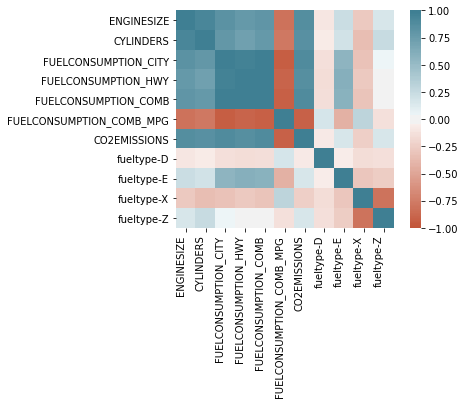

In [13]:
corr = X.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

AS WE CAN SEE THAT FUELCONSUMPTION_CITY,FUELCONSUMPTION_HIGH,FUELCONSUMPTION_COMB IS HEAVILY CORRELATED  SO WE CAN REMOVE CITY BUT IT IS THEY ARE ALSO HIGHLY CORRELATED WITH CO2 EMSSIONS...BUT VARIABLES WITHIN CORRELATED DISTURB THE MODEL AND HENCE THEY HAVE TO BE REMOVED AND THEN CHECKED AGAIN

In [14]:
X = data.drop(['CO2EMISSIONS','CYLINDERS','MODELYEAR','MAKE','MODEL','VEHICLECLASS','TRANSMISSION','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB_MPG'], axis='columns')
Y=data['CO2EMISSIONS']

FUELTYPE IS NOT CORRELATED BUT WE WILL TAKE IT AGAIN SO AS TO KEEP SOME MODELS INSIDE IT

In [15]:
data.columns

Index(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY',
       'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS',
       'fueltype-D', 'fueltype-E', 'fueltype-X', 'fueltype-Z'],
      dtype='object')

In [16]:
X.head()

,ENGINESIZE,FUELCONSUMPTION_COMB,fueltype-D,fueltype-E,fueltype-X,fueltype-Z
0,2.0,8.5,0,0,0,1
1,2.4,9.6,0,0,0,1
2,1.5,5.9,0,0,0,1
3,3.5,11.1,0,0,0,1
4,3.5,10.6,0,0,0,1


In [17]:
Y.head()

0    196
1    221
2    136
3    255
4    244
Name: CO2EMISSIONS, dtype: int64

In [18]:
#SCALING THE VALUES(EXCLUDED ONE-HOT ENCODED VALUES)

X['ENGINESIZE'] = (X['ENGINESIZE'] - X['ENGINESIZE'].min()) / (X['ENGINESIZE'].max() - X['ENGINESIZE'].min())
X['FUELCONSUMPTION_COMB'] = (X['FUELCONSUMPTION_COMB'] - X['FUELCONSUMPTION_COMB'].min()) / (X['FUELCONSUMPTION_COMB'].max() - X['FUELCONSUMPTION_COMB'].min())

In [19]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=2)
print("train set:", X_train.shape)
print("test set:", X_test.shape)

train set: (853, 6)
test set: (214, 6)


In [20]:
X_train.head()

,ENGINESIZE,FUELCONSUMPTION_COMB,fueltype-D,fueltype-E,fueltype-X,fueltype-Z
645,0.270270,0.601896,0,1,0,0
939,0.000000,0.080569,0,0,0,1
70,0.405405,0.436019,0,0,0,1
200,0.108108,0.165877,0,0,1,0
470,0.581081,0.649289,0,1,0,0


In [21]:
X_test.head()

,ENGINESIZE,FUELCONSUMPTION_COMB,fueltype-D,fueltype-E,fueltype-X,fueltype-Z
455,0.581081,0.379147,0,0,1,0
954,0.202703,0.369668,0,0,0,1
738,0.608108,0.398104,0,0,0,1
913,0.270270,0.279621,1,0,0,0
702,0.067568,0.127962,0,0,1,0


In [22]:
y_train

645    278
939    147
70     320
200    189
470    294
      ... 
360    230
466    230
299    294
493    216
527    248
Name: CO2EMISSIONS, Length: 853, dtype: int64

In [23]:
linear=linear_model.LinearRegression()
ridge = linear_model.Ridge()
lasso= linear_model.Lasso()
elastic = linear_model.ElasticNet()
bayes_ridge = linear_model.BayesianRidge(n_iter=1000)
sgd = linear_model.SGDRegressor(max_iter=100000)

In [24]:
models = [linear,ridge, lasso, elastic, bayes_ridge,sgd]

In [25]:
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model,'\nCV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [26]:
# loop through list of models
for model in models:
  get_cv_scores(model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
CV Mean:  0.9878392976260442
STD:  0.004740174491154404


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) 
CV Mean:  0.9758409673990368
STD:  0.0042711703765946135


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) 
CV Mean:  0.9468639359134663
STD:  0.009107360212398838


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
CV Mean:  0.16475669045369765
STD:  0.010925042570736414


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=Tru

###So now the best models are in :1)Linear & 2)BayesianRidge Regresssion but we will solve each and every model  

##**Linear Regression**

In [27]:
from sklearn.linear_model import LinearRegression
lre=LinearRegression()
lre.fit(X_train, y_train)
lre.score(X_test, y_test)

0.990352419394397

In [28]:
#Using cross-Validation for better & accuarte results
from sklearn.model_selection import cross_val_score
Rcross = cross_val_score(lre, X_train, y_train, cv=4)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.9886497051733331 and the standard deviation is 0.0019323609564059385


In [29]:
#Prediction of values
y_test_pred = lre.predict(X_test)

In [30]:
print('Mean squared error: %.2f'% mean_squared_error(y_test,y_test_pred))
print('Coefficient of determination: %.7f'% r2_score(y_test,y_test_pred))

Mean squared error: 44.67
Coefficient of determination: 0.9903524


In [31]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 7))

Mean absolute error = 3.54
Mean squared error = 44.67
Median absolute error = 1.84
Explain variance score = 0.99
R2 score = 0.9903524


In [32]:
linear.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [33]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

fit_intercept=[False,True]

param_grid = dict(fit_intercept=fit_intercept)

#Specifying the value of the cv attribute will trigger the use of cross-validation with GridSearchCV, 
#for example cv=10 for 10-fold cross-validation, rather than Generalized Cross-Validation.
Grid1 = GridSearchCV(estimator=linear, param_grid=param_grid, verbose=1, n_jobs=-1,cv=10,scoring='r2')
Grid1.fit(X_train,y_train)

BestLinearR=Grid1.best_estimator_
print("\nGrid Search",BestLinearR.score(X_test, y_test))

Grid2 = RandomizedSearchCV(estimator=linear, param_distributions=param_grid, verbose=1, n_jobs=-1,cv=10,scoring='r2')
Grid2.fit(X_train,y_train)

BestLinearR=Grid2.best_estimator_
BestLinearR.score(X_test, y_test)
print("\nRandom Search",BestLinearR.score(X_test, y_test))


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search 0.990352419394397
Fitting 10 folds for each of 2 candidates, totalling 20 fits

Random Search 0.990352419394397


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


###Both of Searches have same R^2 value so the final R^2 value is given below:
###**R^2 : 0.9903524**

##**Ridge Regression**

In [34]:
from sklearn.linear_model import Ridge
RigeModel=Ridge(alpha=0.1) # setting the regularization parameter to 0.1
RigeModel.fit(X_train, y_train)
RigeModel.score(X_test, y_test)
y_test_pred = RigeModel.predict(X_test)

In [35]:
RigeModel.score(X_test, y_test)

0.9898943423677532

Understanding behaviour of Alpha with R^2 value

In [36]:
Rsqu_test = []
Rsqu_train = []
dummy1 = []
ALFA = 10 * np.array(range(0,1000))
for alfa in ALFA:
    RigeModel = Ridge(alpha=alfa) 
    RigeModel.fit(X_train, y_train)
    Rsqu_test.append(RigeModel.score(X_test, y_test))
    Rsqu_train.append(RigeModel.score(X_train, y_train))

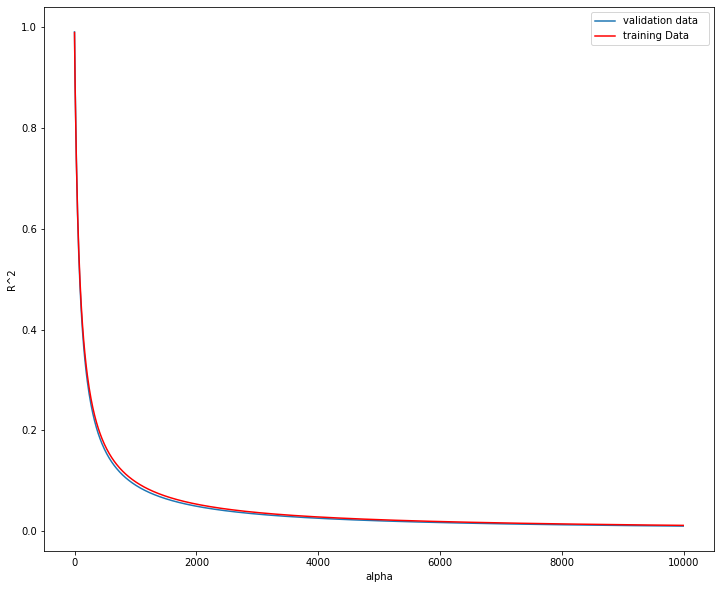

In [37]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(ALFA,Rsqu_test, label='validation data  ')
plt.plot(ALFA,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

###**Ridge Regression with Best Parameter**

###Now we will find best hyperparameter alpha using Grid Search in Ridge Model only



In [38]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

alpha = [0.001,0.1,0.5, 1]
solver = ['auto', 'svd']
fit_intercept=[False,True]

param_grid = dict(alpha=alpha,
                  solver=solver,
                  fit_intercept=fit_intercept)

#Specifying the value of the cv attribute will trigger the use of cross-validation with GridSearchCV, 
#for example cv=10 for 10-fold cross-validation, rather than Generalized Cross-Validation.
Grid1 = GridSearchCV(estimator=ridge, param_grid=param_grid, verbose=1, n_jobs=-1,cv=10,scoring='r2')
Grid1.fit(X_train,y_train)

Grid1 = RandomizedSearchCV(estimator=ridge, param_distributions=param_grid, verbose=1, n_jobs=-1,cv=10,scoring='r2')
Grid1.fit(X_train,y_train)

BestRRG=Grid1.best_estimator_
print("\nGrid Search Best Score: ",BestRRG.score(X_test, y_test))

Grid2 = RandomizedSearchCV(estimator=ridge, param_distributions=param_grid, verbose=1, n_jobs=-1,cv=10,scoring='r2')
Grid2.fit(X_train,y_train)

BestRRR=Grid2.best_estimator_
print("\nRandom Search Best Score: ",BestRRR.score(X_test, y_test))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search Best Score:  0.9903489682283481
Fitting 10 folds for each of 10 candidates, totalling 100 fits

Random Search Best Score:  0.9903489682283481


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [39]:
y_test_pred = BestRRG.predict(X_test)

In [40]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(BestRRG.score(X_test, y_test), 7))

Mean absolute error = 3.55
Mean squared error = 44.69
Median absolute error = 1.84
Explain variance score = 0.99
R2 score = 0.990349


In [41]:
#Can use RidgeCV also but we got with GridSearchCV only
from sklearn import linear_model

reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X_train,y_train)
reg.alpha_

0.01

So we created 2 models:

1) Ridge Regression Model:

**R^2:     0.9898943423677532**

2) Ridge Regression Model with best Parameter

**R^2:  0.990349**

##**Lasso Regression**

In [42]:
from sklearn.linear_model import Lasso
LassoModel=Lasso() # setting the regularization parameter to 0.1
LassoModel.fit(X_train, y_train)
LassoModel.score(X_test, y_test)
y_test_pred = LassoModel.predict(X_test)
LassoModel.score(X_test, y_test)

0.9472101397321239

In [43]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(LassoModel.score(X_test, y_test), 7))

Mean absolute error = 11.4
Mean squared error = 244.45
Median absolute error = 8.01
Explain variance score = 0.95
R2 score = 0.9472101


###**Lasso Regression with Best Parameters**

In [44]:
alpha = [0.001,0.1,0.5, 1]#No solver is there
fit_intercept=[False,True]

param_grid = dict(alpha=alpha, fit_intercept=fit_intercept)

Grid2 = GridSearchCV(estimator=lasso, param_grid=param_grid, verbose=1, n_jobs=-1,cv=10)
Grid2.fit(X_train,y_train)

BestLRG=Grid2.best_estimator_
print("\nGrid Search Best Score: ",BestLRG.score(X_test, y_test))

Grid3 = RandomizedSearchCV(estimator=lasso, param_distributions=param_grid, verbose=1, n_jobs=-1,cv=10,scoring='r2')
Grid3.fit(X_train,y_train)

BestLRR=Grid3.best_estimator_
print("\nRandom Search Best Score: ",BestLRR.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search Best Score:  0.9903295192218332
Fitting 10 folds for each of 8 candidates, totalling 80 fits

Random Search Best Score:  0.9903295192218332


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.5s finished


In [45]:
#Both value are same..can take any of them
#So taking grid ...
BestLR=Grid2.best_estimator_
BestLR.score(X_test, y_test)

0.9903295192218332

In [46]:
y_test_pred = BestLR.predict(X_test)

In [47]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(BestLR.score(X_test, y_test), 7))

Mean absolute error = 3.57
Mean squared error = 44.78
Median absolute error = 1.87
Explain variance score = 0.99
R2 score = 0.9903295


So we created 2 models:

1) Lasso Regression Model

**R^2:      0.9472101**

2) Lasso Regression Model with best Parameter

**R^2: 0.9903295**

##**Bayesian Ridge Regression**

In [48]:
bayes_ridge = linear_model.BayesianRidge()
alpha_1=[np.exp(-6),np.exp(-5),np.exp(-4)]
alpha_2=[np.exp(-6),np.exp(-5),np.exp(-4)]
lambda_1=[np.exp(-6),np.exp(-5),np.exp(-4)]
lambda_2=[np.exp(-6),np.exp(-5),np.exp(-4)]
alpha_init=None
lambda_init=None
compute_score=[False,True]
fit_intercept=[False,True]
normalize=[False,True]
 
param_grid = dict(alpha_1=alpha_1,
                  alpha_2=alpha_2,lambda_1=lambda_1,lambda_2=lambda_2)
 
grids = GridSearchCV(estimator=bayes_ridge, param_grid=param_grid, verbose=1, n_jobs=-1,cv=10)
grids.fit(X_train, y_train)

BestBRG=grids.best_estimator_
print("\nGrid Search Best Score: ",BestBRG.score(X_test, y_test))

Random = RandomizedSearchCV(estimator=bayes_ridge, param_distributions=param_grid, verbose=1, n_jobs=-1,cv=10)
Random.fit(X_train, y_train)


BestBRR=Random.best_estimator_
print("\Random Search Best Score: ",BestBRR.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search Best Score:  0.9903488758814121
Fitting 10 folds for each of 10 candidates, totalling 100 fits
\Random Search Best Score:  0.9903488759199582


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [49]:
#As Random Search had higher value than Random Search
y_test_pred = BestBRR.predict(X_test)

In [50]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(BestBRR.score(X_test, y_test), 7))

Mean absolute error = 3.55
Mean squared error = 44.69
Median absolute error = 1.84
Explain variance score = 0.99
R2 score = 0.9903489


###**R^2: 0.9903489**

##**SGD REGRESSOR**

In [51]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [52]:
alpha = [0.001,0.1,0.5, 1]
penalty=['l2', 'l1', 'elasticnet']
fit_intercept=[True,False]

param_grid = dict(alpha=alpha,
                  penalty=penalty,max_iter=[10000],
                  fit_intercept=fit_intercept)

#Specifying the value of the cv attribute will trigger the use of cross-validation with GridSearchCV, 
#for example cv=10 for 10-fold cross-validation, rather than Generalized Cross-Validation.
Grid1 = GridSearchCV(estimator=sgd, param_grid=param_grid, verbose=1, n_jobs=-1,cv=5,scoring="r2")
Grid1.fit(X_train,y_train)

BestSGDG=Grid1.best_estimator_
print("\nGrid Search Best Score: ",BestSGDG.score(X_test, y_test))

Random = RandomizedSearchCV(estimator=sgd, param_distributions=param_grid, verbose=1, n_jobs=-1,cv=5)
Random.fit(X_train, y_train)


BestSGDR=Random.best_estimator_
print("\Random Search Best Score: ",BestSGDR.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   15.0s finished



Grid Search Best Score:  0.9895741841883127
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.0s finished


\Random Search Best Score:  0.9883583669448133


In [53]:
#As Grid Search has higher score lets take it
y_test_pred = BestSGDG.predict(X_test)

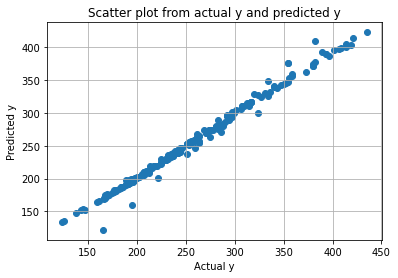

In [54]:
plt.scatter(y_test,y_test_pred)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter plot from actual y and predicted y')
plt.show()

In [55]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(BestSGDG.score(X_test, y_test), 7))

Mean absolute error = 4.17
Mean squared error = 48.28
Median absolute error = 2.62
Explain variance score = 0.99
R2 score = 0.9895742


###**R^2: 0.9895586**

##**Elastic Net**

In [56]:
from sklearn.linear_model import ElasticNet,ElasticNetCV
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_ratio=[0,0.25,0.5,0.75,1]

param_grid = dict(alpha=alphas,max_iter=[10000],l1_ratio=l1_ratio)

#Specifying the value of the cv attribute will trigger the use of cross-validation with GridSearchCV, 
#for example cv=10 for 10-fold cross-validation, rather than Generalized Cross-Validation.
Grid3 = GridSearchCV(estimator=elastic, param_grid=param_grid, verbose=1, n_jobs=-1,cv=10,scoring="r2")
Grid3.fit(X_train,y_train)

BestENG=Grid3.best_estimator_
print("\nGrid Search Best Score: ",BestENG.score(X_test, y_test))

Random = RandomizedSearchCV(estimator=elastic, param_distributions=param_grid, verbose=1, n_jobs=-1,cv=5)
Random.fit(X_train, y_train)

BestENR=Random.best_estimator_
print("\Random Search Best Score: ",BestENR.score(X_test, y_test))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search Best Score:  0.9903448364462129
Fitting 5 folds for each of 10 candidates, totalling 50 fits
\Random Search Best Score:  0.9903448364462129


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


In [57]:
#as value of grid is better so using grid searchBestEN=Grid3.best_estimator_
y_test_pred = BestENG.predict(X_test)

In [58]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(BestENG.score(X_test, y_test), 7))#The Model Name

Mean absolute error = 3.55
Mean squared error = 44.71
Median absolute error = 1.85
Explain variance score = 0.99
R2 score = 0.9903448


###**R^2: 0.9903448**

###Checking changes of R2 & other parameters according to alpha

In [59]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_test, y_test)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.99, MSE:45.45, RMSE:6.74
Alpha:0.0010, R2:0.99, MSE:59.19, RMSE:7.69
Alpha:0.0100, R2:0.94, MSE:275.84, RMSE:16.61
Alpha:0.1000, R2:0.66, MSE:1562.62, RMSE:39.53
Alpha:0.3000, R2:0.40, MSE:2785.18, RMSE:52.77
Alpha:0.5000, R2:0.29, MSE:3294.90, RMSE:57.40
Alpha:0.7000, R2:0.23, MSE:3579.09, RMSE:59.83
Alpha:1.0000, R2:0.17, MSE:3832.89, RMSE:61.91


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20970.99877815401, tolerance: 328.96459695193437
  positive)


In [60]:
#Using CV for validating the results but in Grid Search already applied Cv so no need of this method actually 
elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
elastic_cv.fit(X_train, y_train)
print(elastic_cv.alpha_)
print(elastic_cv.intercept_)

0.0001
105.18646040830703


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8753.049587067835, tolerance: 265.33791085043987
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7075.889641729801, tolerance: 260.7308897360703
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8166.386977725228, tolerance: 260.94778181818197
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to incr

In [61]:
ypred = elastic_cv.predict(X_test)
score = elastic_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, ypred)
print("R2:{0:.7f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))
 

R2:0.9901849, MSE:45.45, RMSE:6.74


#**IRIS DATASET**


In [62]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
 
iris = load_iris()
X=iris.data
Y=iris.target

In [63]:
X=pd.DataFrame(X)

In [64]:
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [65]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

In [66]:
seed = 8
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=test_size, random_state=seed)

In [93]:
logistic = linear_model.LogisticRegression(solver='liblinear')#liblinear: Optimizer like  Gradient dissent
#CV Mean:  0.875
#STD:  0.03535533905932741

sgd = linear_model.SGDClassifier()
#CV Mean:  0.8916666666666666
#STD:  0.023570226039551608

ridge = linear_model.RidgeClassifier()

models = [logistic, sgd,ridge]

In [94]:
def get_cv_scores(model):
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [95]:
# loop through list of models
for model in models:
    print(model)
    get_cv_scores(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
CV Mean:  0.875
STD:  0.03535533905932741


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
CV Mean:  0.8583333333333334
STD:  0.08249579113843052


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,

##As SGD mean is higher then Logistic Mean &  SGD SD is Lesser than Logistics SD.Hence we choose SGD for Final Modelling

In [81]:
loss = ['hinge', 'log']
penalty = ['l1', 'l2']
alpha = [0.0001, 0.001]
learning_rate = ['constant', 'optimal']
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}]
eta0 = [1, 10]

param = dict(loss=loss,
                           penalty=penalty,
                           alpha=alpha,
                           learning_rate=learning_rate,
                           class_weight=class_weight,
                           eta0=eta0)

Grid = GridSearchCV(estimator=sgd, param_grid=param, verbose=1, n_jobs=-1,cv=10,scoring='accuracy')
Grid.fit(X_train, y_train)
print("\nGrid Search Best Score: ",Grid.best_score_)

random = RandomizedSearchCV(estimator=sgd, param_distributions=param, scoring='accuracy', verbose=1, n_jobs=-1, n_iter=1000)
random.fit(X_train, y_train)
print('\nBest Score  of Random : ', random.best_score_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 64 is smaller than n_iter=1000. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search Best Score:  0.9583333333333333
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best Score  of Random :  0.9583333333333334


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.9s finished


In [82]:
#Since both have same score so choose any ...chossing random
BestModel=random.best_estimator_
print(BestModel)

SGDClassifier(alpha=0.001, average=False, class_weight={0: 0.5, 1: 0.5},
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [84]:
from sklearn.metrics import accuracy_score

BestModel.fit(X_train, y_train)

y_train_pred = BestModel.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
print("Accuracy of Train: %.2f%%" % (accuracy_train))


y_test_pred = BestModel.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy of Test : %.2f%%" % (accuracy_test))

Accuracy of Train: 0.97%
Accuracy of Test : 0.93%


###Training Accuracy: 97%
###Testing Accuracy: 93%

###Now as there is not much difference between Train & Testing accuracy.So the trainign Model perfectly fits the Testing Model. 

###**Logistic is done below  only to prove that SGD is best by comparing the results**

In [85]:
#class sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, 
#iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)

#n_jobs int, default=None
#Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,cv=10)
grid.fit(X_train, y_train)
print("\nGrid Search Best Score: ",grid.best_score_)

random = RandomizedSearchCV(estimator=logistic, param_distributions=param_grid, scoring='accuracy', verbose=1, n_jobs=-1, n_iter=1000,cv=10)
random.fit(X_train, y_train)
print('\nBest Score  of Random : ', random.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=1000. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search Best Score:  0.8083333333333333
Fitting 10 folds for each of 24 candidates, totalling 240 fits

Best Score  of Random :  0.8083333333333333


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished


In [86]:
#As both Models are same we can  taken any so taking Grid Search
logistic=grid.best_estimator_
print(logistic)

LogisticRegression(C=0.01, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [87]:
from sklearn.metrics import accuracy_score

logistic.fit(X_train, y_train)

y_train_pred = logistic.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy_train))

y_test_pred = logistic.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy: %.2f%%" % (accuracy_test))

Accuracy: 0.82%
Accuracy: 0.70%


###**Logistc training & Testing accuracy is very less so hence proved for IRIS dataset.SGD is the perfect model**

##**Ridge Classifier CV**

In [99]:
alpha = [0.01,0.001,0.0001,1.0]
fit_intercept=[False,True]

param = dict(alpha=alpha,fit_intercept=fit_intercept)

Grid = GridSearchCV(estimator=ridge, param_grid=param, verbose=1, n_jobs=-1,cv=10,scoring='accuracy')
Grid.fit(X_train, y_train)
print("\nGrid Search Best Score: ",grid.best_score_)

random = RandomizedSearchCV(estimator=ridge, param_distributions=param, scoring='accuracy', verbose=1, n_jobs=-1, n_iter=1000,cv=5)
random.fit(X_train, y_train)
print('\nBest Score  of Random : ', random.best_score_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Grid Search Best Score:  0.8083333333333333
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Score  of Random :  0.875


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=1000. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
#as Random Search has greater score ..hence using Random  

In [100]:
#As both Models are same we can  taken any so taking Grid Search
ridgemodel=random.best_estimator_
print(ridgemodel)

RidgeClassifier(alpha=0.01, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)


In [101]:
from sklearn.metrics import accuracy_score

ridgemodel.fit(X_train, y_train)

y_train_pred = ridgemodel.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy_train))

y_test_pred = ridgemodel.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy: %.2f%%" % (accuracy_test))

Accuracy: 0.88%
Accuracy: 0.77%


**Train Accuracy: 88%**

**Testing Accuracy : 77%**



---

